#### Portfolio optimization of crypto currencies:
a popular technique that financial and investment advisors use to help ensure that their clients are taking appropriate risk to meet their financial objectives.

Section 1: Focusing on collecting the data necessary for analysis. Closing price for top10 coins according to marketcap. Use API CoinGecko to grab daily closing price in USD for 365 days during bear market (from 01.01.2019 - 31.12.2019).
BTC ETH XRP ADA LTC BNB BCH XLM BSV EOS

Section 2: Preparing the data to calculate a few different metrics: expected returns, expected volatility, and the sharpe ratio.

Section 3: Building a simulation that will randomly generate results that we can use to help to determine the optimal results for a wide range of portfolios.

Section 4: Taking this simulation, plot them using matplotlib, using scipy library to run an optimization algorthim that will return the best weights for our simulation


In [ ]:
import pandas as pd
import requests
import json
import numpy as np
import time
from functools import reduce
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sci_plt

from pprint import pprint
from sklearn.preprocessing import StandardScaler

# Set some display option for Pandas

pd.set_option("display.max_colwidth", None)
pd.set_option("expand_frame_repr", False)

### Section 1 Grabbing the data from CoinGecko

Firstly to get the correct IDs

In [ ]:
base = "https://api.coingecko.com/api/v3/"
url = base + "/coins/list"
response = requests.get(url)
results = response.json()
df_list = pd.DataFrame(results).set_index("id")
df_list.to_csv("coins_list.csv")
# df_list[df_list['symbol'].str.match("bnb")] : binancecoin
# df_list[df_list['symbol'].str.match("bch")] : bitcoin-cash
# df_list[df_list['symbol'].str.match("bsv")] : bitcoin-cash-sv

Secondly to generate a dataframe of all the prices from 01.Jan.19 to 31.12.19

In [ ]:
'''all_coins = []
base = "https://api.coingecko.com/api/v3/"
ids = ["bitcoin", "ethereum", "ripple", "cardano", "litecoin", "binancecoin", "bitcoin-cash", "stellar", "bitcoin-cash-sv", "eos"]
for coin in ids:
    url = base + "/coins/"+ coin + "/market_chart/range"
    param_dict = {"id":coin, "vs_currency":"usd", "from":"1546297200", "to":"1577833200"}
    response = requests.get(url, params=param_dict)
    results = response.json()
    df = pd.DataFrame(results["prices"], columns=["time", coin])
    df["time"] = pd.to_datetime(df["time"], unit="ms")
    # df_all = pd.merge(df_all, df, how="left", on="time")
    all_coins.append(df)

all_coins_merged = reduce(lambda df1, df2: pd.merge(df1,df2, how="left", on="time"), all_coins)
all_coins_merged.set_index("time", inplace=True)

all_coins_merged.to_csv("all_coins_2019.csv")

'''

### Section 2 Metrics
When we compare the performance of an investment, we should take both return and risk into consideration. Most investors aren't okay with taking on high-levels of risk, so the goal is to find the best ratio of risk vs returns. Ideally, we are taking the most risk we are comfortable with and attempting to maximize those returns. That naturally leads to an important question, "How do we measure risk?". There are different ways to measure risk, in this workbook, we will use a very popular metric, the Sharpe Ratio. The Sharpe Ratio, is used as a measure for calculating risk-adjusted return and has been the industry standard for such calculations. The Sharpe Ratio allows us to quantify the relationship the average return earned in excess of the risk-free rate per unit of volatility or total risk.

Mathematically, we define the Sharpe Ratio as the following:

$$\begin{equation*}
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
\end{equation*}$$
Where:

$
\begin{align}
\ R_p = \text{Return of Portfolio} \\
\ R_f = \text{Risk-Free Rate} \\
\ \sigma_p = \text{Standard Deviation of Portfolio's Excess Return} \\
\end{align}
$

To calculate the expected returns, we use the following formula:

$$\begin{equation*}
\ R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
\end{equation*}$$
Where:

$
\begin{align}
\ r_{i} = \text{Return of Security i} \\
\ w_{i} = \text{Weight of Security i} \\
\end{align}
$

To calculate the standard deviation of the protfolio, we use the following formula:

$$\begin{equation*}
\ \sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
\end{equation*}$$
Where:

$
\begin{align}
\ \sigma_{i}  = \text{Standard Deviation of Returns for Security i} \\
\ w_{i}  = \text{Weight of Security i} \\
\ p_{i,j}  = \text{Correlation Coefficent between the returns of asset i and asset j} \\
\end{align}
$

In [ ]:
# read csv file
all_coins_merged = pd.read_csv("all_coins_2019.csv")
all_coins_merged.set_index("time", inplace=True)
all_coins_merged.head()

In [ ]:
ids = ["bitcoin", "ethereum", "ripple", "cardano", "litecoin", "binancecoin", "bitcoin-cash", "stellar", "bitcoin-cash-sv", "eos"]
# log return over time
# calculate the log returns
log_return = np.log(1 + all_coins_merged.pct_change())

# generate random weights
random_weights = np.array(np.random.random(len(ids)))

# generate rebalanced random weights, sum up to 1
rebalanced_weights = random_weights / np.sum(random_weights)
rebalanced_weights

# calculate the expected returns and annualised it 365
exp_ret = np.sum((log_return.mean() * rebalanced_weights)*365)

# calculate the expected volatility and annualised it
exp_vol = np.sqrt(
    np.dot(
        rebalanced_weights.T,
        np.dot(
            log_return.cov() * 365,
            rebalanced_weights
        )  
    )
)

# calculate the sharpe ratio. Assumed that the risk free rate is 1%

sharpe_ratio = (exp_ret - 0.01) / exp_vol

# put the weights into a data frame for a better overview
weights_df = pd.DataFrame(data={
            "random_weights" : random_weights,
            "rebalanced_weights" : rebalanced_weights
})

print("")
print("*"*100)
print("Portfolio Weights:")
print("*"*100)
print(weights_df)
print("-"*100)

# put the other metrics into a data frame for a better overview
metrics_df = pd.DataFrame(data={
            "Expected Portfolio Returns" : exp_ret,
            "Expected Portfolio Volatility" : exp_vol,
            "Portfolio Sharpe Ratio" : sharpe_ratio
}, index=[0])
print("")
print("*"*100)
print("Portfolio Metrics:")
print("*"*100)
print(metrics_df)
print("-"*100)

In [ ]:
log_return.hist(bins=100, figsize=(12,8))
plt.tight_layout()


In [ ]:
log_return.corr()

### Section 3 Portfolio Optimization: Monte Carlo

By calculating the expected returns, the expected volatility and using the Sharpe Ratio to quantify how well the portfolio is allocated based on a risk perspective. The question is, "if we know that we want to get a higher sharpe ratio, what is the portfolio allocation we need to achieve this?"

There are two ways to approach this question. 
1) We could test a bunch of different random allocations and see which ones produces the highest Sharpe Ratio.
2) We could use mathematical optimization defined by some constrains to arrive at the optimial allocation -> Monte Carlo simulations

Monte Carlo simulations are used to model the probability of different outcomes in a process that cannot easily be predicted due to the intervention of random variables. It is a technique used to understand the impact of risk and uncertainty in prediction and forcasting models.

To do this, we can run the process we performed a couple thousands of time and store the results of each run in a data frame. once we've completed each run, we will find the allocations that produce the highest Sharpe Ratio and lowest Volatility.

In [ ]:
# define the number of times that we want to run the simulation

num_of_simulations = 10000

# set the weight array by using numpy zeros

all_weights_array = np.zeros((num_of_simulations, len(ids)))

# set the returns array by using numpy zeros

ret_array = np.zeros(num_of_simulations)

# set the volatility array by using numpy zeros
vol_array = np.zeros(num_of_simulations)

# set the sharpe ratio array by using numpy zeros

sharpe_array = np.zeros(num_of_simulations)

# start the simulation
for trial in range(num_of_simulations):
    
    # firt, calculate the weights
    weights = np.array(np.random.random(len(ids)))
    weights = weights / np.sum(weights)
    
    # add the weights to the "weights_array"
    all_weights_array[trial, :] = weights
    
    # calculate the expected log returns
    ret_array[trial] = np.sum((log_return.mean() * weights)*365)
    
    # calculate the volatility
    vol_array[trial] = np.sqrt(
      np.dot(weights.T, np.dot(log_return.cov() * 365, weights))
    )
    
    # calculate the sharpe ratio
    sharpe_array[trial] = ret_array[trial] / vol_array[trial]

# combine them 
simulations_data = [ret_array, vol_array, sharpe_array, all_weights_array]

# create a Dataframe from the master array
simulations_df = pd.DataFrame(data=simulations_data).T

# give the columns name
simulations_df.columns = ["Returns", "Volatility", "Sharpe Ratio", "Portfolio Weights"]

# make sure the data types are correct
simulations_df = simulations_df.infer_objects()

# print out the results
print("")
print("*"*127)
print("Simulations Reuslts:")
print("-"*127)
display(simulations_df.head())
print("-"*127)

### Obtain the important metrics

In [ ]:
# grab the max sharpe ratio

max_sharpe_ratio = simulations_df.loc[simulations_df["Sharpe Ratio"].idxmax()]

# grab the max return

max_return = simulations_df.loc[simulations_df["Returns"].idxmax()]

# return the min volatility
min_vol = simulations_df.loc[simulations_df["Volatility"].idxmin()]

print("")
print(["bitcoin", "ethereum", "ripple", "cardano", "litecoin", "binancecoin", "bitcoin-cash", "stellar", "bitcoin-cash-sv", "eos"])
print("")
print("*"*127)
print("Max Sharpe Ratio:")
print("-"*127)
print(max_sharpe_ratio)
print("-"*127)

print("")
print("*"*127)
print("Max Returns:")
print("-"*127)
print(max_return)
print("-"*127)

print("")
print("*"*127)
print("Min Volatility:")
print("-"*127)
print(min_vol)
print("-"*127)

### Section 4 Plotting


In [ ]:
# plot the data on a scatter plot

plt.scatter(
    y=simulations_df["Returns"],
    x=simulations_df["Volatility"],
    c=simulations_df["Sharpe Ratio"],
    cmap="RdYlBu"
)

# give title
plt.title("Portfolio Returns vs Risks")
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Standard Deviation")
plt.ylabel("Returns")

# plot the max Sharpe ratio using a red star
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker="X",
    color="r",
    s=600
)

# plot the min volatility using a red star
plt.scatter(
    min_vol[1],
    min_vol[0],
    marker="X",
    color="b",
    s=600
)

# plot the max return using a yellow star
plt.scatter(
    max_return[1],
    max_return[0],
    marker="X",
    color="y",
    s=600
)

### Using unsupervised learning to classify the coins

In [ ]:
# select only the real coin, exclude the non-coin ids
# df_list = pd.read_csv("coins_list.csv")
# df_coins = df_list[~df_list["id"].str.contains("-")].reset_index()
# df_coins.drop(columns="index",inplace=True)
# df_coins.head()

In [ ]:
# I realized that if there is no-coin ids, the api will return NaN, as it is not easy to identify all the non-coin ids
# I decided to grab everything from the coins_list and drop the columns with no values.
df_list = pd.read_csv("coins_list.csv")
coin_ids = list(df_list["id"])
coin_ids_chunck = np.array_split(coin_ids, 130)
coin_ids_chunck

In [ ]:
'''# grab return from 01.Aug.19 to 31.Dec.19 for the coins in the list

for i in range(91,131):
    
    base = "https://api.coingecko.com/api/v3/"
    coins_return = []

    for coin in coin_ids_chunck[i]:
        try:
     
            url = base + "/coins/"+ coin + "/market_chart/range"
            param_dict = {"id":coin, "vs_currency":"usd", "from":"1564614000", "to":"1577833200"}
            response = requests.get(url, params=param_dict)
            results = response.json()
            
            if results["prices"] != []:
                df_coin = pd.DataFrame(results["prices"], columns=["time", coin])
                df_coin["time"] = pd.to_datetime(df_coin["time"], unit="ms")
                coins_return.append(df_coin)
                coins_return_merged = reduce(lambda df1, df2: pd.merge(df1,df2, how="left", on="time"), coins_return)
                coins_return_merged.set_index("time", inplace=True)    

            else:
                continue
        except:
            pass
            
    filename = "\\chunk_coin_return\\df_" + coin
    coins_return_merged.to_csv(os.getcwd() + filename + ".csv")      
    time.sleep(30)'''

In [ ]:
'''# merge all the files and drop the columns with more than 10% NA

path = "chunk_coin_return"
all_filenames = os.listdir(path)

#combine all files in the list

file_all = []
for file in all_filenames:
    filepath = path + "/" + file
    df = pd.read_csv(filepath)
    file_all.append(df)
file_all

coins_merged = reduce(lambda df1,df2: pd.merge(df1,df2, how="left", on='time'), file_all)

coins_merged.to_csv("coins_merged.csv")'''

In [ ]:
# clean the dataset 

coins_merged = pd.read_csv("coins_merged.csv")
col_name = coins_merged.columns[coins_merged.isnull().sum() > 20]
coins_merged_clean = coins_merged.drop(columns=col_name)
coins_merged_clean = coins_merged_clean.drop(coins_merged_clean.columns[0], axis=1)
coins_merged_clean.set_index("time", inplace=True)


In [ ]:
# calculate the annulised log return 
log_return = np.log(1 + coins_merged_clean.pct_change())
# calculate the expected returns and annualised it 365
annual_return_s = (log_return.mean() *365)
df_coins = pd.DataFrame(annual_return_s)
df_coins = df_coins.reset_index()
df_coins.rename({"index":"coins", 0:"annualised_return"}, axis=1, inplace=True)
df_coins



In [ ]:
# calculate daily standard deviation of returns
daily_std = np.std(coins_merged_clean)
  
# annualized daily standard deviation
std = daily_std * 365 ** 0.5

df_std = pd.DataFrame(std)
df_std = df_std.reset_index()
df_std.rename({"index":"coins", 0:"annualised_std"}, axis=1, inplace=True)

df_std

In [ ]:
# combine the daily log return and the daily voltility

df_final = df_coins.merge(df_std, how="left", on="coins")
df_final.set_index("coins", inplace=True)

In [ ]:
# create a statistical summary

desc_df = df_final.describe()

# add the standard deviation metric
desc_df.loc["+3_std"] = desc_df.loc["mean"] + (desc_df.loc["std"] * 3)
desc_df.loc["-3_std"] = desc_df.loc["mean"] - (desc_df.loc["std"] * 3)

# display 
desc_df

In [ ]:
df_final.nlargest(50, columns="annualised_std")

In [71]:
# clustering coins by K-mean

from sklearn.cluster import KMeans
from sklearn import metrics


# create a dictionary to store our scores
results_dict = {}

# define the number of the iterations
num_of_clusters = 20

# run through each k

for k in range(2, num_of_clusters):
    
    print("-"*100)
    
    # define the key for this iteration
    results_dict[k] = {}
    
    # create an instance of the kmeans model
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(df_final)
    
    # define silhouette score
    sil_score = metrics.silhouette_score(df_final, kmeans.labels_, metric = "euclidean")
    
    # store the different metrics
    results_dict[k]["silhouette_score"] = sil_score
    results_dict[k]["inertia"] = kmeans.inertia_
    results_dict[k]["score"] = kmeans.score
    results_dict[k]["model"] = kmeans
    
    # print out the results
    
    print("The number of clusters: {}".format(k))
    print("Silhouette Score: {}".format(sil_score))

----------------------------------------------------------------------------------------------------
The number of clusters: 2
Silhouette Score: 0.9971488929495268
----------------------------------------------------------------------------------------------------
The number of clusters: 3
Silhouette Score: 0.9974674957395956
----------------------------------------------------------------------------------------------------
The number of clusters: 4
Silhouette Score: 0.9956657346076225
----------------------------------------------------------------------------------------------------
The number of clusters: 5
Silhouette Score: 0.9938157296496429
----------------------------------------------------------------------------------------------------
The number of clusters: 6
Silhouette Score: 0.9886719339974028
----------------------------------------------------------------------------------------------------
The number of clusters: 7
Silhouette Score: 0.9887838900689842
----------------

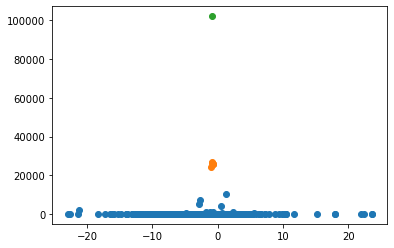

In [82]:
kmeans = KMeans(n_clusters=3, random_state = 0).fit(df_final)

# fit model and predict clusters
df_final['clusters'] = model.fit_predict(df_final)
# # create scatter plot for samples from each cluster
clusterval = df_final['clusters'].unique()
for cluster in clusterval:
    plt.scatter(df_final[df_final['clusters']==cluster]["annualised_return"], df_final[df_final['clusters']==cluster]["annualised_std"])
plt.show()
